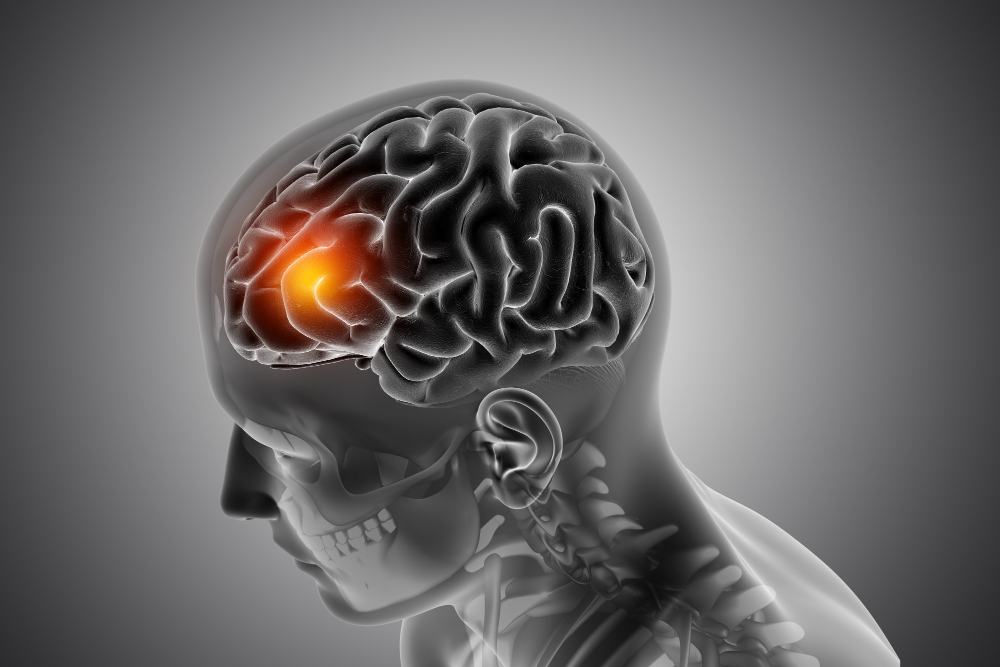

# Brain Tumor MRI Classification using Deep Learning

## Introduction

Brain tumors are among the most critical neurological conditions and require early and accurate diagnosis to improve patient outcomes. Magnetic Resonance Imaging (MRI) is one of the most commonly used imaging techniques for detecting brain tumors, but manual analysis of MRI scans can be time-consuming and prone to human error.

This project explores the use of **deep learning and transfer learning** to automatically classify brain MRI images into four categories:
- Glioma
- Meningioma
- Pituitary tumor
- No tumor

We leverage **pretrained convolutional neural networks (CNNs)** trained on the ImageNet dataset and fine-tune them for this medical imaging task. Specifically, we implement and compare the performance of:
- **InceptionResNetV2**
- **DenseNet201**

Both models are evaluated using standard classification metrics such as accuracy, precision, recall, F1-score, and confusion matrices to understand their strengths and limitations.

The goal of this notebook is not only to build accurate models but also to demonstrate a clear and reproducible workflow, including data preprocessing, model training, evaluation, and comparison.


### 0. Importing Required Libraries

This section imports all the libraries used throughout the notebook. The libraries are grouped based on their purpose to improve readability and maintainability.

- **System & File Handling**: Used for accessing datasets stored on Google Drive and navigating directories.
- **Numerical & Visualization Tools**: Used for numerical computations and plotting images, metrics, and evaluation results.
- **TensorFlow & Keras**: Core deep learning framework used to build, train, and evaluate convolutional neural networks.
- **Pretrained Models**: InceptionResNetV2 and DenseNet201 are imported for transfer learning.
- **Evaluation Metrics**: Used to generate confusion matrices and classification reports.
- **Performance Optimization**: Mixed precision is imported to improve training efficiency on compatible hardware.

These imports support the full pipeline, from data loading and preprocessing to model training, evaluation, and visualization.


In [34]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import AdamW
from keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from keras.preprocessing import image_dataset_from_directory

from keras.applications import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
from tensorflow.keras import mixed_precision



---

### 📥 Dataset Download

This project uses the **Brain Tumor MRI Dataset (Glioma, Meningioma, Pituitary, No Tumor)** available on **Mendeley Data**.

**Download Link:**
[https://data.mendeley.com/datasets/zwr4ntf94j](https://data.mendeley.com/datasets/zwr4ntf94j)

The dataset contains MRI images organised into **train** and **test** folders, with four tumour classes. After downloading, extract the archive and update the dataset path in the notebook accordingly.

---


In [2]:
#load the dataset from google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/Brain Tumor Data/Epic and CSCR hospital Dataset'
train_dir = os.path.join(data_dir,'Train')
test_dir = os.path.join(data_dir,'Test')

## 1. Dataset Configuration and Loading

In this section, the MRI brain tumor dataset is loaded using TensorFlow’s
`image_dataset_from_directory` utility. This function automatically assigns
class labels based on the folder structure, making it well-suited for
multi-class image classification problems.

### Key Configurations

- **Batch Size**:  
  A batch size of 32 is used to balance memory efficiency and training speed.

- **Image Size**:  
  All images are resized to **299 × 299** pixels. This is required because
  the InceptionResNetV2 architecture expects inputs of this size.

- **Shuffle Strategy**:
  - Training dataset is shuffled to improve generalization and prevent
    the model from learning the order of the data.
    - Test dataset is *not shuffled* to ensure consistent and reproducible
      evaluation results.

The dataset is split into training and testing folders, with each class
stored in a separate subdirectory.


In [4]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = (299,299) #Resize for InceptionResNetV2

In [5]:
train_ds = image_dataset_from_directory(
   train_dir,
   image_size = IMAGE_SIZE,
   batch_size = BATCH_SIZE,
   shuffle = True,
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 9650 files belonging to 4 classes.
Found 2414 files belonging to 4 classes.


## Dataset Inspection and Visualization

Before training the model, it is important to verify that the dataset has been
loaded correctly. In this section, a single batch of images and labels is
extracted from the training dataset to:

- Confirm image and label shapes
- Verify class-to-label mapping
- Visually inspect sample MRI images
- Ensure labels correspond correctly to class names

This step helps catch issues such as incorrect resizing, label mismatch,
or class imbalance early in the pipeline.


In [6]:
images,labels = next(iter(train_ds))

print("batch shape",images.shape)
print("labels shape",labels.shape)


#map label indices to class names

class_names = train_ds.class_names
print(class_names)

batch shape (32, 299, 299, 3)
labels shape (32,)
['glioma', 'meningioma', 'notumor', 'pituitary']


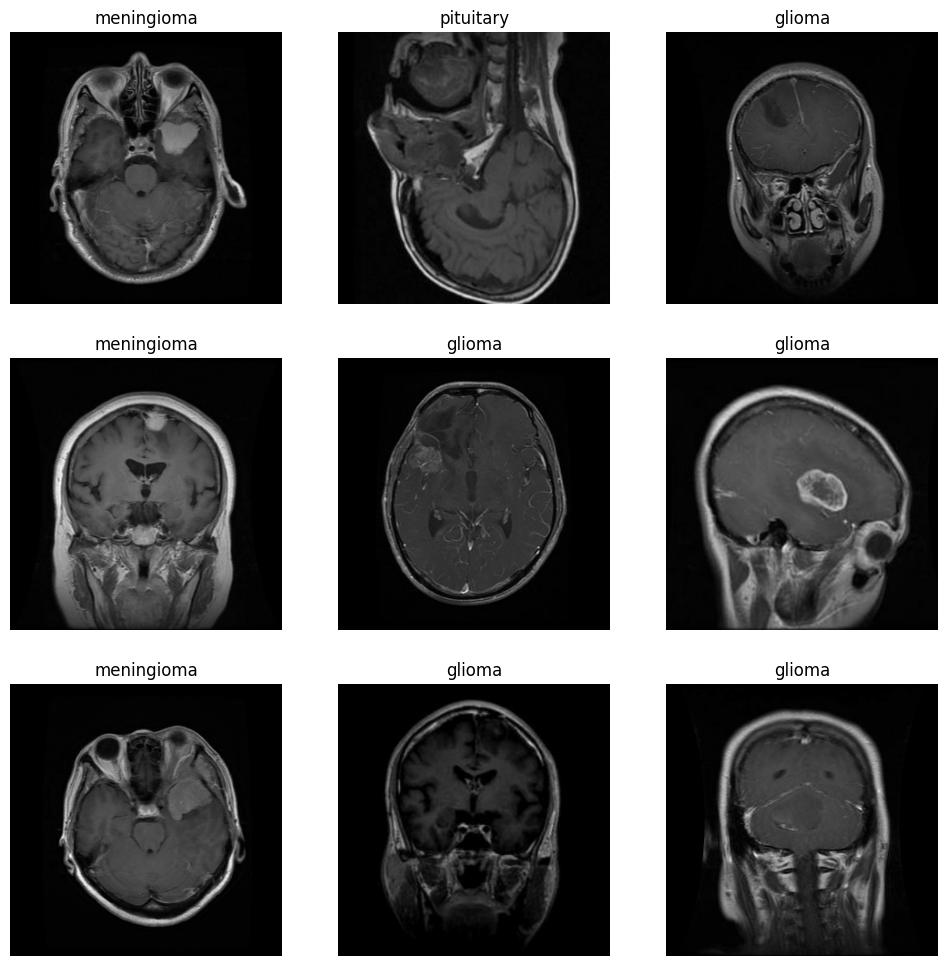

In [7]:

plt.figure(figsize=(12,12))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(class_names[labels[i]])
  plt.axis("off")
plt.show()

## Prospective Models

- InceptionResNetV2
- DenseNet201



##InceptionResNetV2



### Data Augmentation
We apply horizontal flipping, rotation, and zoom to improve model generalization.


This helps reduce overfitting, especially when working with medical imaging datasets.

In [8]:
#Augmentation

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1)
]
)

TensorFlow’s `prefetch` mechanism is used to optimize the input
pipeline and improve training performance by overlapping data loading with model execution.

In [9]:
#Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [10]:
base = InceptionResNetV2(include_top=False, weights='imagenet',input_shape=(299,299,3))
base.trainable = False #freeze first phase

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


The InceptionResNetV2 architecture is used as a feature extractor via
transfer learning. Pretrained ImageNet weights allow the model to leverage
rich visual features learned from large-scale datasets, while a custom
classification head is added for the brain tumor classification task.

In [11]:
#add classification head

inputs = keras.Input(shape=(299,299,3))
x = data_augmentation(inputs)
x = keras.applications.inception_resnet_v2.preprocess_input(x)


x = base(x,training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(4, activation= "softmax")(x)

model = keras.Model(inputs,outputs)

## Model Compilation and Phase 1 Training (Frozen Base Model)

After constructing the InceptionResNetV2-based model, the next step is to compile
and train it. During this phase, the pretrained base model remains frozen, meaning
only the newly added classification layers are trained.

The Adam optimizer is used with a low learning rate to ensure stable convergence.
Sparse categorical cross-entropy is selected as the loss function since class labels
are encoded as integers rather than one-hot vectors.

To prevent overfitting and unnecessary training, Early Stopping is applied by
monitoring the validation loss. The best-performing model weights are also saved
automatically using a model checkpoint callback.


In [13]:
#compile

model.compile(
    optimizer = keras.optimizers.Adam(1e-4),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)


callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        restore_best_weights = True
    ),

    keras.callbacks.ModelCheckpoint('best_model_phase1.keras',monitor ='val_loss',save_best_only=True)
]

#Train the model(base frozen)

history_phase1=model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 15,
    callbacks = callbacks
)

Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 215s 658ms/step - accuracy: 0.5518 - loss: 1.0680 - val_accuracy: 0.6972 - val_loss: 0.8204
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 170ms/step - accuracy: 0.6882 - loss: 0.8305 - val_accuracy: 0.7113 - val_loss: 0.7310
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 170ms/step - accuracy: 0.7230 - loss: 0.7357 - val_accuracy: 0.7220 - val_loss: 0.6906
Epoch 4/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 52s 171ms/step - accuracy: 0.7469 - loss: 0.6839 - val_accuracy: 0.7299 - val_loss: 0.6674
Epoch 5/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 52s 171ms/step - accuracy: 0.7592 - loss: 0.6463 - val_accuracy: 0.7361 - val_loss: 0.6425
Epoch 6/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 52s 172ms/step - accuracy: 0.7745 - loss: 0.6108 - val_accuracy: 0.7436 - val_loss: 0.6296
Epoch 7/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - accuracy: 0.7765 - loss: 0.5984 - val_accuracy: 0.7436 - val_loss: 0.6191
Epoch 8/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - accuracy: 0.7820 - loss: 

## Phase 2: Fine-Tuning the Pretrained Model

After completing the initial training phase with the base model frozen, the next step
is fine-tuning. Fine-tuning allows the model to adapt the higher-level pretrained
features to the specific task of brain tumor MRI classification.

In this phase:
- The base InceptionResNetV2 model is unfrozen.
- Only the top layers of the base model are made trainable, while the lower layers
  remain frozen to preserve generic visual features.
- A much smaller learning rate is used to avoid destroying pretrained weights.
- The AdamW optimizer is selected to improve generalization by applying weight decay.

This approach helps improve performance while reducing the risk of overfitting.


In [14]:

#unfreeze top layers of the base
base.trainable = True
#freeze lower layers,finetune top layers only
for layer in base.layers[:-100]:
  layer.trainable = False
#compile with AdmaW

model.compile(
    optimizer = AdamW(learning_rate=1e-5,weight_decay=1e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

callbacks_phase2 = [
    keras.callbacks.EarlyStopping(
        monitor= 'val_loss',
        patience=5,
        restore_best_weights=True
    ),

    keras.callbacks.ModelCheckpoint('best_model_phase2.keras',monitor='val_loss',save_best_only=True)
]

history_phase2 = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 10,
    callbacks = callbacks_phase2
)



Epoch 1/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 102s 235ms/step - accuracy: 0.7783 - loss: 0.6406 - val_accuracy: 0.8061 - val_loss: 0.4869
Epoch 2/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 63s 210ms/step - accuracy: 0.8759 - loss: 0.3541 - val_accuracy: 0.8467 - val_loss: 0.3908
Epoch 3/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 63s 210ms/step - accuracy: 0.9180 - loss: 0.2484 - val_accuracy: 0.8592 - val_loss: 0.3735
Epoch 4/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 63s 210ms/step - accuracy: 0.9425 - loss: 0.1760 - val_accuracy: 0.8952 - val_loss: 0.3026
Epoch 5/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 63s 207ms/step - accuracy: 0.9530 - loss: 0.1364 - val_accuracy: 0.9031 - val_loss: 0.2955
Epoch 6/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 63s 208ms/step - accuracy: 0.9637 - loss: 0.1101 - val_accuracy: 0.9147 - val_loss: 0.2572
Epoch 7/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 64s 211ms/step - accuracy: 0.9714 - loss: 0.0861 - val_accuracy: 0.9358 - val_loss: 0.2054
Epoch 8/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 60s 200ms/step - accuracy: 0.9797 - loss: 

In [15]:
model.evaluate(test_ds)

76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.9294 - loss: 0.2383


[0.19701367616653442, 0.9436619877815247]

## Model Evaluation

To thoroughly evaluate the performance of the trained InceptionResNetV2 model,
we analyze its predictions on the test dataset using:

- A confusion matrix to visualize class-wise prediction performance
- A classification report to compute precision, recall, F1-score, and overall accuracy

These metrics provide deeper insight beyond accuracy, especially for multi-class
medical image classification tasks where class imbalance may exist.


76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step


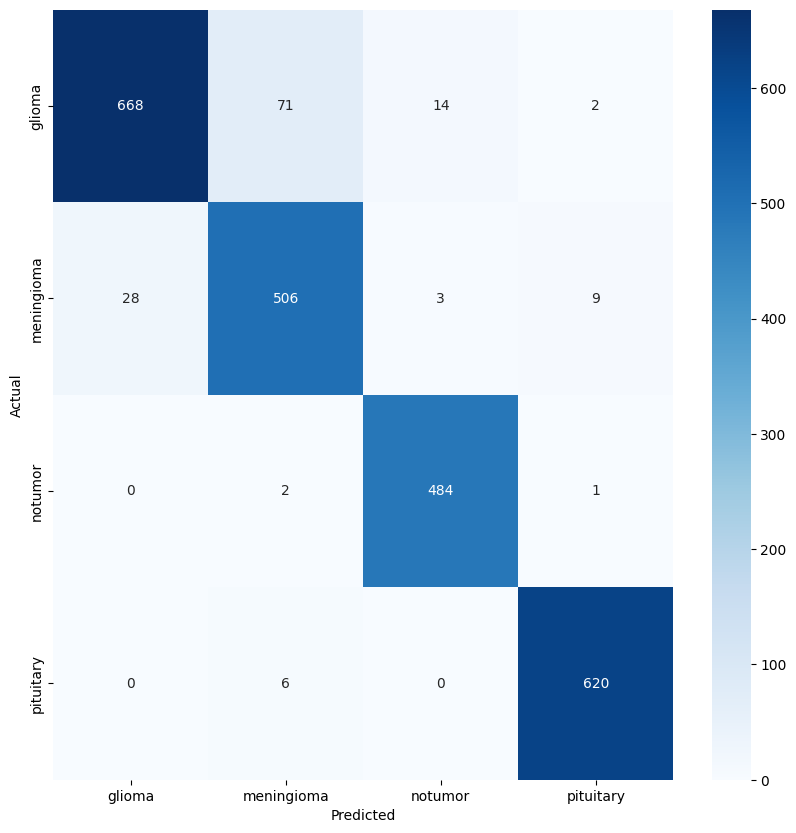

              precision    recall  f1-score   support

      glioma       0.96      0.88      0.92       755
  meningioma       0.86      0.93      0.89       546
     notumor       0.97      0.99      0.98       487
   pituitary       0.98      0.99      0.99       626

    accuracy                           0.94      2414
   macro avg       0.94      0.95      0.95      2414
weighted avg       0.95      0.94      0.94      2414



In [16]:
#Confusion Matrix

class_names = sorted(os.listdir("/content/drive/MyDrive/Brain Tumor Data/Epic and CSCR hospital Dataset/Test"))


labels = np.concatenate([y for x , y in test_ds])
preds = np.argmax(model.predict(test_ds),axis = 1)
cm = confusion_matrix(labels,preds)


plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",xticklabels=class_names,yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(labels,preds,target_names=class_names))


DenseNet201Base

## Loading Training and Test Datasets

The dataset is loaded again using the new image size required by DenseNet201.

- Images are resized to 224×224
- Labels are returned as integers
- Training data is shuffled to improve learning
- Test data is not shuffled to preserve evaluation order


In [17]:
from tensorflow.keras import backend as K
import gc

K.clear_session()
gc.collect()

0

In [18]:
IMAGE_SIZE_2 = (224,224)
BATCH_SIZE_2 = 32

In [19]:



train_ds = image_dataset_from_directory(
   train_dir,
   image_size = IMAGE_SIZE_2,
   batch_size = BATCH_SIZE_2,
   label_mode = 'int',
   shuffle = True,
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size = IMAGE_SIZE_2,
    batch_size = BATCH_SIZE_2,
    label_mode = 'int',
    shuffle = False
)






Found 9650 files belonging to 4 classes.
Found 2414 files belonging to 4 classes.


TensorFlow’s `prefetch` mechanism is used to optimize the input
pipeline and improve training performance by overlapping data loading with model execution.

In [20]:
#Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [21]:
input_shape = (224,224,3)
#load base model with imagenet weights,excluding the top
base = DenseNet201(
    include_top = False,
    weights = 'imagenet',
    input_shape = input_shape
)

base.trainable = False

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Data Augmentation
We apply horizontal flipping, rotation, and zoom to improve model generalization.


This helps reduce overfitting, especially when working with medical imaging datasets.

In [22]:
#Augmentation
inputs= layers.Input(shape=input_shape)
x = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1)
]
)(inputs)

## DenseNet201 Model Architecture (Phase 1: Feature Extraction)

In this phase, DenseNet201 is used as a **pretrained feature extractor**.
The convolutional base is frozen, and only the newly added classification
head is trained.

This approach:
- Preserves learned ImageNet features
- Reduces training time
- Prevents overfitting on a relatively small medical dataset


In [23]:
#preprocess input for densenet

from tensorflow.keras.applications.densenet import preprocess_input
x = preprocess_input(x)


#pass through base

x = base(x,training= False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4,activation="softmax")(x)

model = Model(inputs,outputs)

In [24]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer = Adam(1e-4),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

In [25]:
callbacks_phase1 = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        restore_best_weights = True
    ),

    keras.callbacks.ModelCheckpoint('best_densenet201_model_phase1.keras',monitor ='val_loss',save_best_only=True)
]

#Train the model(base frozen)

history_phase1=model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 15,
    callbacks = callbacks_phase1)

Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 84s 212ms/step - accuracy: 0.3405 - loss: 1.4964 - val_accuracy: 0.6114 - val_loss: 0.9612
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.6233 - loss: 0.9322 - val_accuracy: 0.7096 - val_loss: 0.7787
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.7193 - loss: 0.7614 - val_accuracy: 0.7162 - val_loss: 0.7196
Epoch 4/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.7496 - loss: 0.6697 - val_accuracy: 0.7307 - val_loss: 0.6630
Epoch 5/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.7789 - loss: 0.6031 - val_accuracy: 0.7374 - val_loss: 0.6410
Epoch 6/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.7870 - loss: 0.5763 - val_accuracy: 0.7411 - val_loss: 0.6244
Epoch 7/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.8006 - loss: 0.5415 - val_accuracy: 0.7572 - val_loss: 0.5866
Epoch 8/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - accuracy: 0.8090 - loss: 0


## DenseNet201 Phase 2: Fine-Tuning

In Phase 2, we **unfreeze the top layers** of the DenseNet201 base to allow
the model to fine-tune high-level features on our dataset.

Why only the top layers?
- The lower layers capture **generic features** like edges and textures,
  which are already well-learned from ImageNet.
- The top layers capture **dataset-specific features** and benefit from
  fine-tuning on brain tumor MRI images.

This approach improves performance while reducing the risk of overfitting.

In [27]:
base.trainable = True
for layer in base.layers[:-100]:
  layer.trainable = False


## Compiling and Training DenseNet201 (Phase 2)

After unfreezing the top layers of DenseNet201, we compile the model with
**AdamW optimizer** for fine-tuning.

Why AdamW?
- AdamW adds **weight decay** to Adam, which helps **regularize** the model.
- Prevents overfitting while training the top layers on our dataset.
- Learning rate is set **very low (1e-5)** to avoid destroying pre-trained weights.

We also define callbacks:
- `EarlyStopping`: Stops training if validation loss doesn't improve for 5 epochs, restoring the best weights.
- `ModelCheckpoint`: Saves the best model based on validation loss.

Finally, we train the model for **10 epochs**, using `train_ds` and `test_ds`.


In [28]:
#compile with AdamW
model.compile(
    optimizer = AdamW(learning_rate=1e-5,weight_decay=1e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

callbacks_phase2 = [
    keras.callbacks.EarlyStopping(
        monitor= 'val_loss',
        patience=5,
        restore_best_weights=True
    ),

    keras.callbacks.ModelCheckpoint('best_densenet201_model_phase2.keras',monitor='val_loss',save_best_only=True)
]

history_phase2 = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 10,
    callbacks = callbacks_phase2
)


Epoch 1/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 100s 203ms/step - accuracy: 0.8007 - loss: 0.5535 - val_accuracy: 0.7945 - val_loss: 0.5199
Epoch 2/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 52s 171ms/step - accuracy: 0.8568 - loss: 0.3997 - val_accuracy: 0.8235 - val_loss: 0.4497
Epoch 3/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - accuracy: 0.8790 - loss: 0.3270 - val_accuracy: 0.8418 - val_loss: 0.4010
Epoch 4/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - accuracy: 0.8947 - loss: 0.2941 - val_accuracy: 0.8546 - val_loss: 0.3693
Epoch 5/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - accuracy: 0.9042 - loss: 0.2667 - val_accuracy: 0.8666 - val_loss: 0.3436
Epoch 6/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 52s 172ms/step - accuracy: 0.9193 - loss: 0.2373 - val_accuracy: 0.8741 - val_loss: 0.3275
Epoch 7/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - accuracy: 0.9273 - loss: 0.2170 - val_accuracy: 0.8811 - val_loss: 0.3128
Epoch 8/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 52s 172ms/step - accuracy: 0.9333 - loss: 

In [29]:
model.evaluate(test_ds)

76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.8703 - loss: 0.3370


[0.2657007575035095, 0.9001656770706177]

In [31]:
#For InceptionNetV2

test_ds_inception = image_dataset_from_directory(
    test_dir,
    image_size =(299,299),
    batch_size = 32,
    label_mode = 'int',
    shuffle = False
)


#For DenseNet201

test_ds_densenet = image_dataset_from_directory(
    test_dir,
    image_size =(224,224),
    batch_size = 32,
    label_mode = 'int',
    shuffle = False
)

Found 2414 files belonging to 4 classes.
Found 2414 files belonging to 4 classes.


## Evaluating and Comparing InceptionResNetV2 and DenseNet201

After training both models, we load the **best saved models** from Phase 2 using `load_model`.

- `inception_model`: InceptionResNetV2 best model
- `densenet_model`: DenseNet201 best model

We then evaluate both models on their respective **test datasets** (`test_ds_inception` and `test_ds_densenet`) to get:
- `loss`: the value of the loss function on the test set
- `accuracy`: the proportion of correctly predicted samples

In [33]:
from tensorflow.keras.models import load_model

#load InceptionResNetV2 model
inception_model = load_model('best_model_phase2.keras')
#load DenseNet201 model
densenet_model = load_model('best_densenet201_model_phase2.keras')

#Evaluate both models on the same test dataset
loss_inc,acc_inc = inception_model.evaluate(test_ds_inception)
loss_den,acc_den = densenet_model.evaluate(test_ds_densenet)


print(f"InceptionResNetV2 Accuracy : {acc_inc*100:.2f}%")
print(f"DenseNet201 Accuracy:{acc_den*100:.2f}%")

76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - accuracy: 0.9294 - loss: 0.2383
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.8703 - loss: 0.3370
InceptionResNetV2 Accuracy : 94.37%
DenseNet201 Accuracy:90.02%
